In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import models
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

> Retrieve the song data from the file provided

In [17]:
songs_df = pd.read_csv('Songs.csv', header = 0)
songs_df.head(3)

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...


> Each entry ends with something like '1EmbedShare URLCopyEmbedCopy', so we removed those appearances from the lyrics.

In [18]:
songs_df['Lyrics'] = songs_df['Lyrics'].str.replace(r'\d+EmbedShare URLCopyEmbedCopy$', "", regex=True)

> Show all unique artists in the dataset

In [19]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 30 Songs
​twenty one pilots: 30 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 30 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> The dataset's size.

In [20]:
print(f'The dataset contains {len(songs_df)} entries for songs.')

The dataset contains 745 entries for songs.


> The dataset contains 3 duplicates so we will need to take care of that.

In [21]:
print(f'The dataset contains {len(songs_df['Title'].unique())} unique songs.')

The dataset contains 742 unique songs.


> Cleanup of duplicates

In [22]:
songs_df = songs_df.drop_duplicates(subset='Title')

In [23]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 29 Songs
​twenty one pilots: 29 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 29 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> Average song length

In [24]:
lengths = songs_df['Lyrics'].apply(lambda x: len(x.split()))

sum_lengths = sum(lengths) / songs_df['Lyrics'].nunique()
print(f'The average number of words in a song is {sum_lengths:.2f}.')

The average number of words in a song is 275.94.


The 3 most common words are:
the: 8124 appearances
you: 7105 appearances
i: 6872 appearances


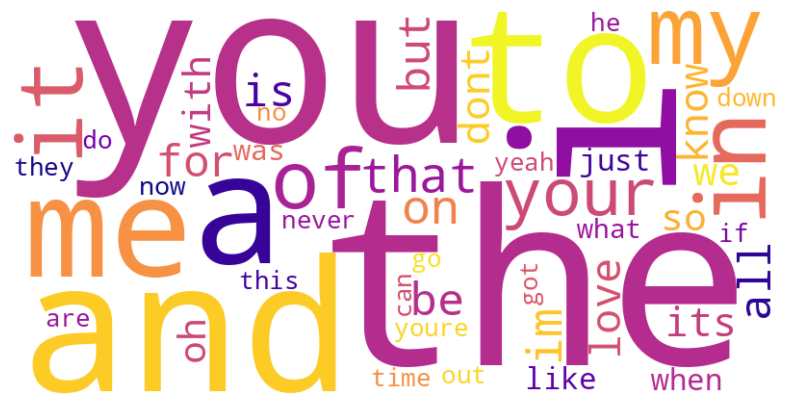

In [27]:
# Ensure you have stopwords downloaded
# nltk.download('stopwords')

# Combine all lyrics into one large text
all_lyrics = " ".join(songs_df["Lyrics"].dropna())

# Clean the text (remove punctuation, convert to lowercase)
all_lyrics = re.sub(r"[^\w\s]", "", all_lyrics.lower())

# Tokenize words
words = all_lyrics.split()

# Remove common stopwords (like "the", "and", etc.)
# stop_words = set(stopwords.words("english"))
# words = [word for word in words if word not in stop_words]

# Count word frequencies
word_counts = Counter(words)

# Get the 3 most common words
print("The 3 most common words are:")
for word, count in word_counts.most_common(3):
    print(f"{word}: {count} appearances")

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='plasma', max_words=50).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
lyrics = songs_df["Lyrics"].dropna().str.lower()

# Tokenization the lyrics removing puncuation
tokenized_lyrics = [re.findall(r"\b\w+\b|\n", lyric) for lyric in lyrics]

# Build vocabulary
word_counts = Counter(word for song in tokenized_lyrics for word in song)
word_to_index = {word: i + 1 for i, (word, _) in enumerate(word_counts.items())}  # Start index from 1
index_to_word = {i: word for word, i in word_to_index.items()}

# Convert lyrics to numerical sequences
encoded_sequences = [[word_to_index[word] for word in song if word in word_to_index] for song in tokenized_lyrics]

# Vocabulary size
vocab_size = len(word_to_index) + 1  # Adding 1 for padding if needed

print(f"Vocabulary Size: {vocab_size}")

In [ ]:
# Set sequence length (choose a reasonable length)
SEQ_LENGTH = 10

# Create input-target pairs
input_sequences = []
targets = []

for song in encoded_sequences:
    for i in range(1, len(song)):
        n_gram_sequence = song[:i+1]  # Create sequence up to current word
        if len(n_gram_sequence) >= 2:  # Ensure sequence has at least one input and one target
            input_sequences.append(n_gram_sequence[:-1])  # All but last word (input)
            targets.append(n_gram_sequence[-1])  # Last word (target)

# Pad sequences to the same length
max_seq_length = SEQ_LENGTH  # Set fixed sequence length
padded_sequences = [([0] * (max_seq_length - len(seq)) + seq)[-max_seq_length:] for seq in input_sequences]

# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)

# PyTorch Dataset
class SongLyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
dataset = SongLyricsDataset(X, y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Dataset Size: {len(dataset)}")

In [ ]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Convert word indices to embeddings
        lstm_out, _ = self.lstm(x)  # LSTM forward pass
        out = self.fc(lstm_out[:, -1, :])  # Get output from last LSTM step
        return out

# Model setup
model = LyricsLSTM(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(data_loader):.4f}")


In [ ]:
def generate_lyrics(seed_text, model, word_to_index, index_to_word, max_words=50):
    model.eval()
    words = seed_text.lower().split()
    
    for _ in range(max_words):
        # Convert words to indices
        encoded_input = [word_to_index.get(word, 0) for word in words][-SEQ_LENGTH:]
        input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)

        # Predict next word
        with torch.no_grad():
            output = model(input_tensor)
            predicted_index = torch.argmax(output, dim=1).item()

        # Convert index to word
        next_word = index_to_word.get(predicted_index, "<UNK>")
        words.append(next_word)

    return " ".join(words)

# Example lyric generation
seed = "I love the way"
generated_text = generate_lyrics(seed, model, word_to_index, index_to_word)
print("\nGenerated Lyrics:\n", generated_text)
